In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(color_codes=True)
sns.set(context='talk')


# this is horrible voodoo to get deprecation warnings to stop
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

    
# load data
with open("data/processed_data.pickle", "rb") as f:
    (
        df_crypto,
        crypto_output_6_covariates,
        crypto_input_6_covariates,
        crypto_output_24_covariates,
        crypto_input_24_covariates,
        crypto_names_of_covariate_groups,
        df_provide,
        provide_output_36_covariates,
        provide_input_36_covariates,
        provide_output_60_covariates,
        provide_input_60_covariates,
        provide_names_of_covariate_groups,
    ) = pickle.load(f)


# load results and models
N_SPLITS_OUTER = 25
with open('data/ml_results.pickle', 'rb') as f:
    all_results = pickle.load(f)

In [2]:
def drop_the_right_rows(df, output_covariate, covariates_to_check='similarityscores'):
    # first drop the rows where there is no output
    df = df.copy()
    df = df.loc[~pd.isnull(df[output_covariate]), :]
    # now drop rows where all of the fnirs are missing
    covariate_missing_flag = df[covariates_to_check].isnull().all(1)
    df = df.loc[~covariate_missing_flag, :]
    return df

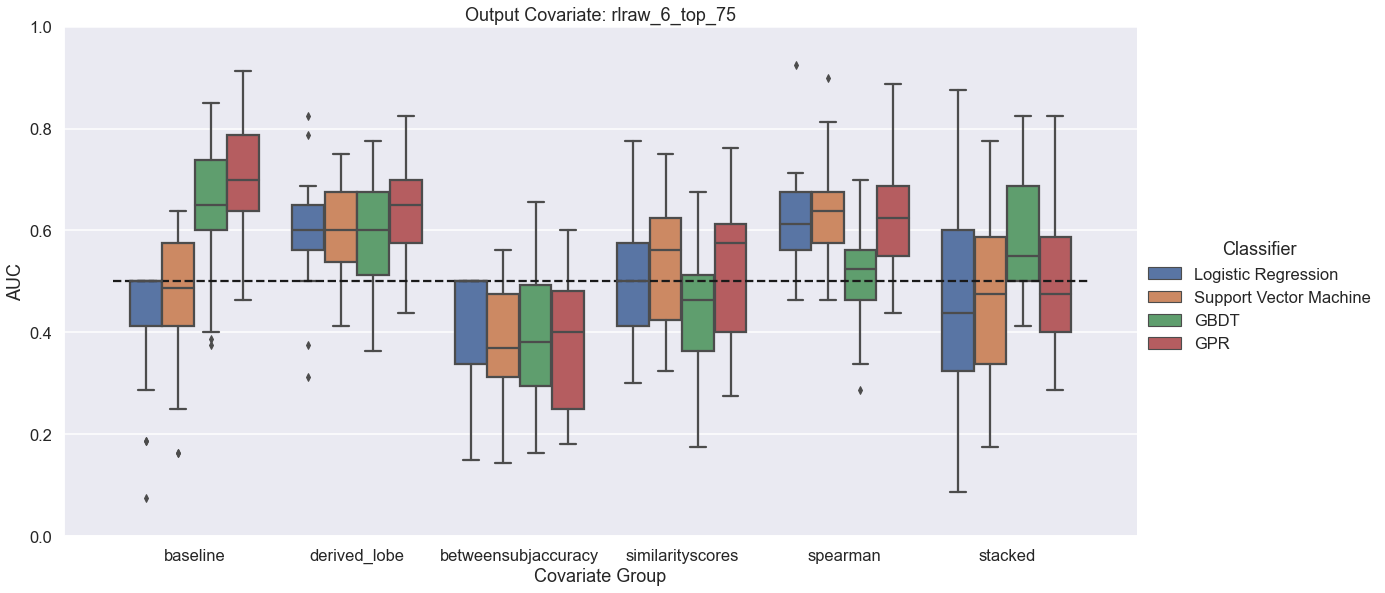

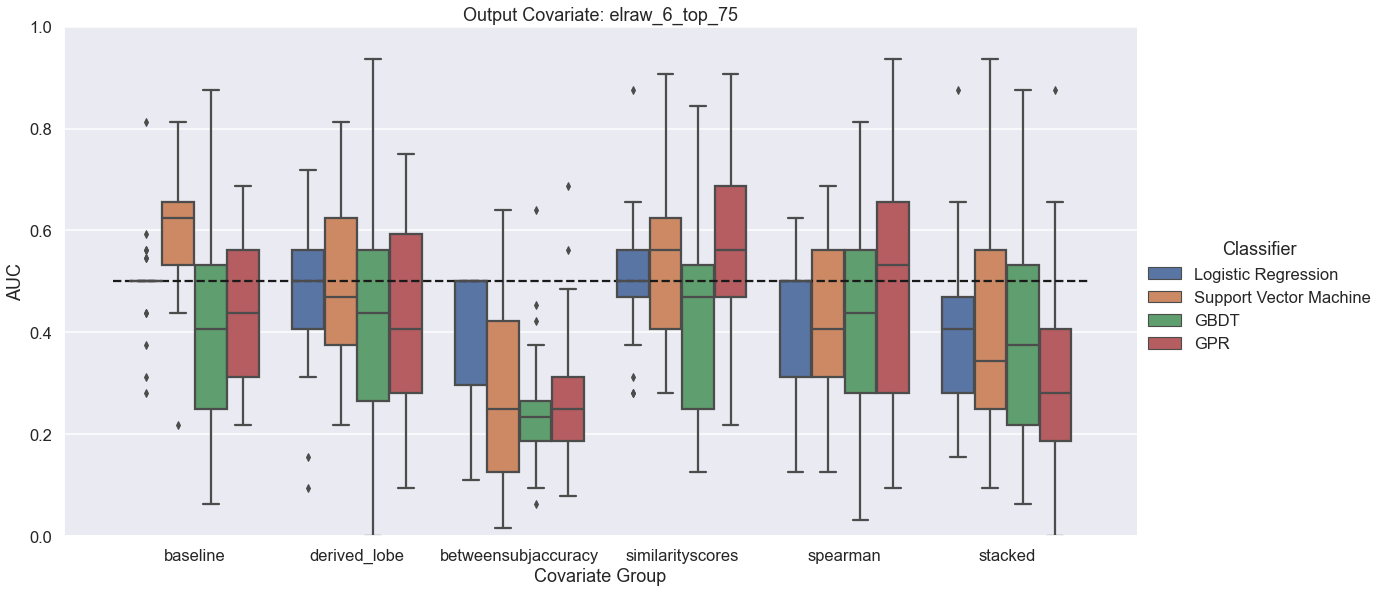

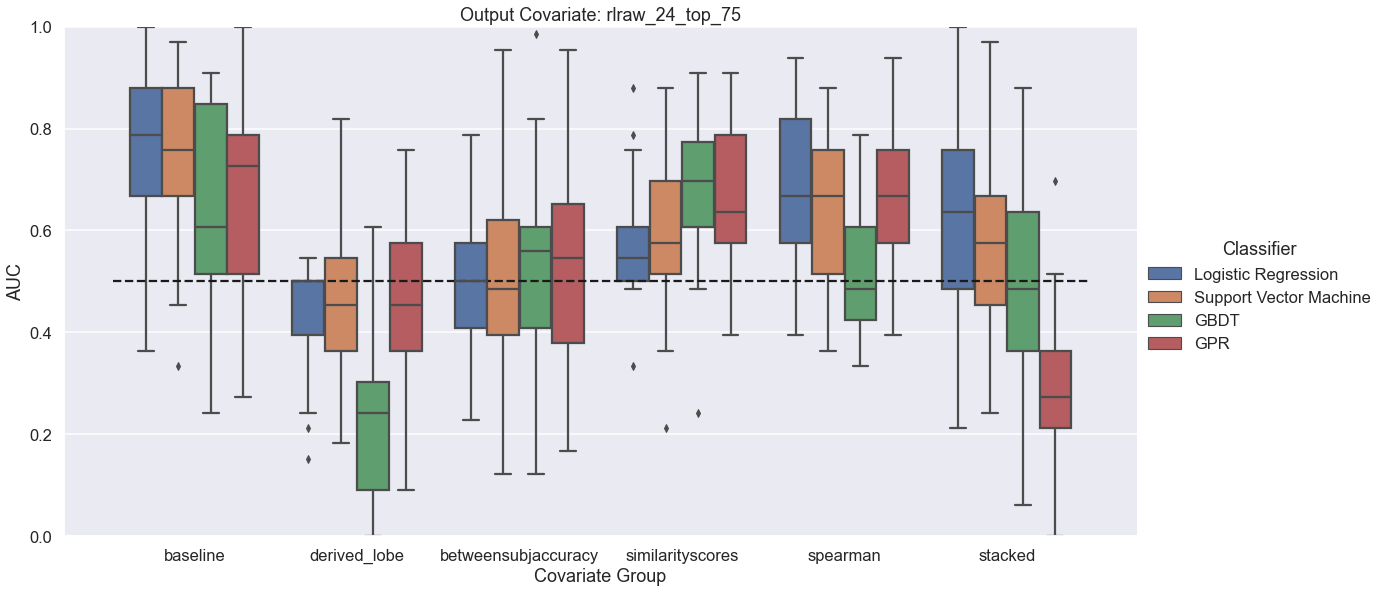

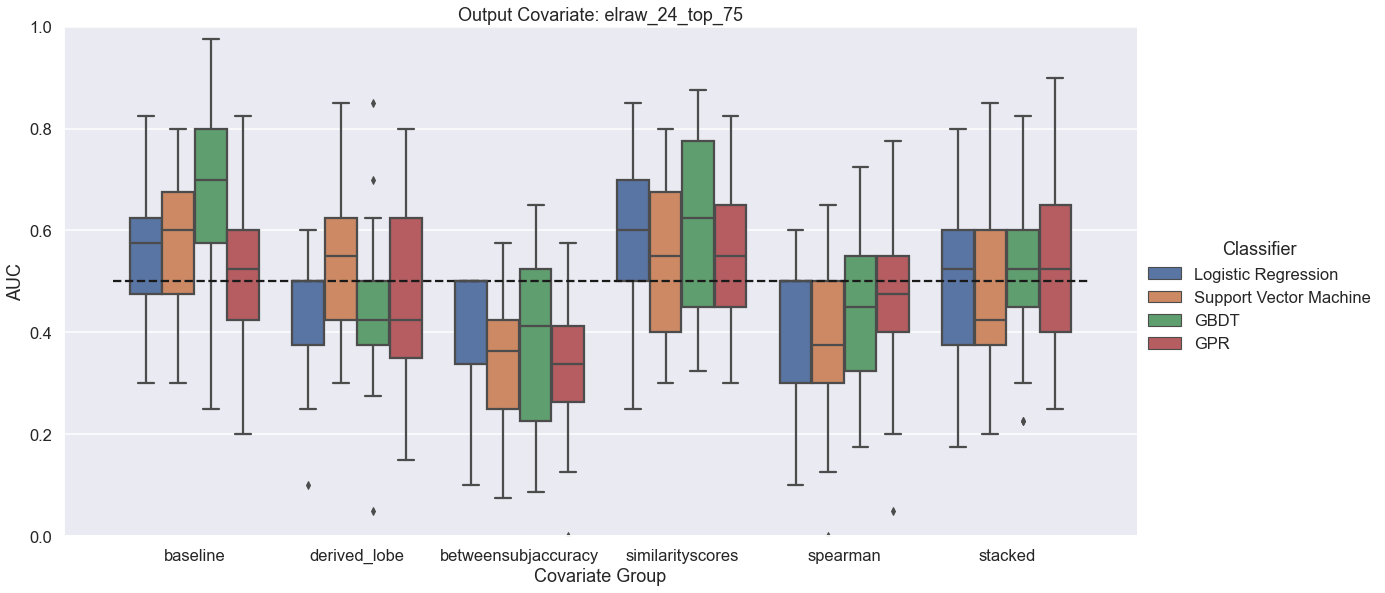

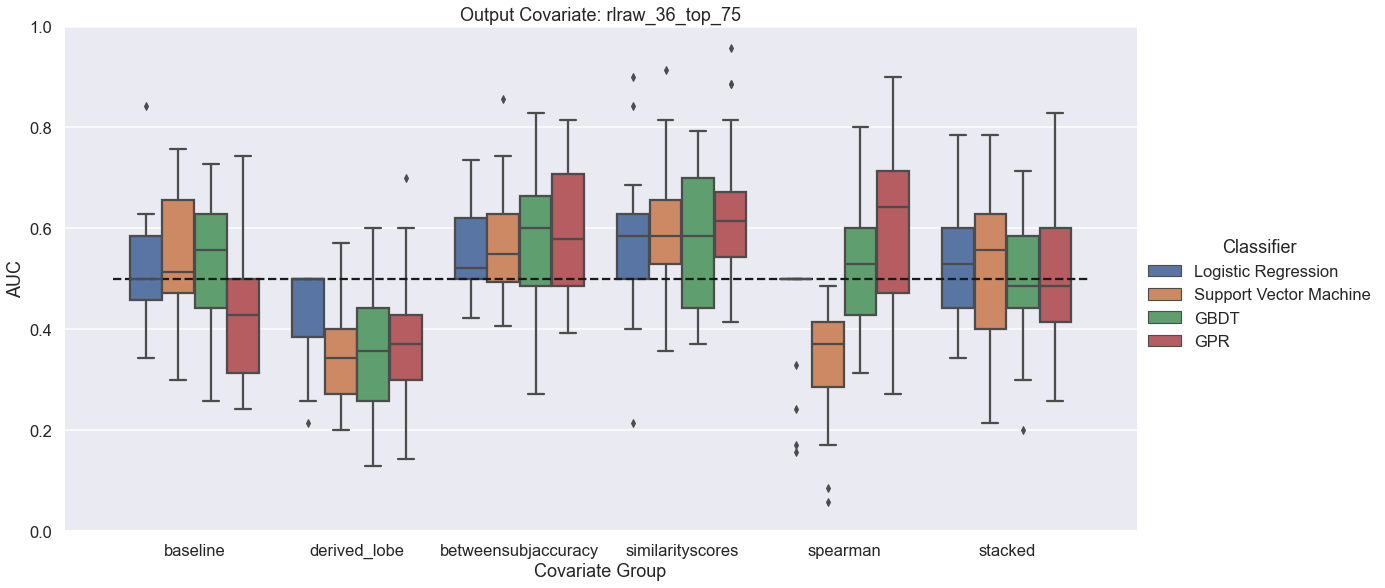

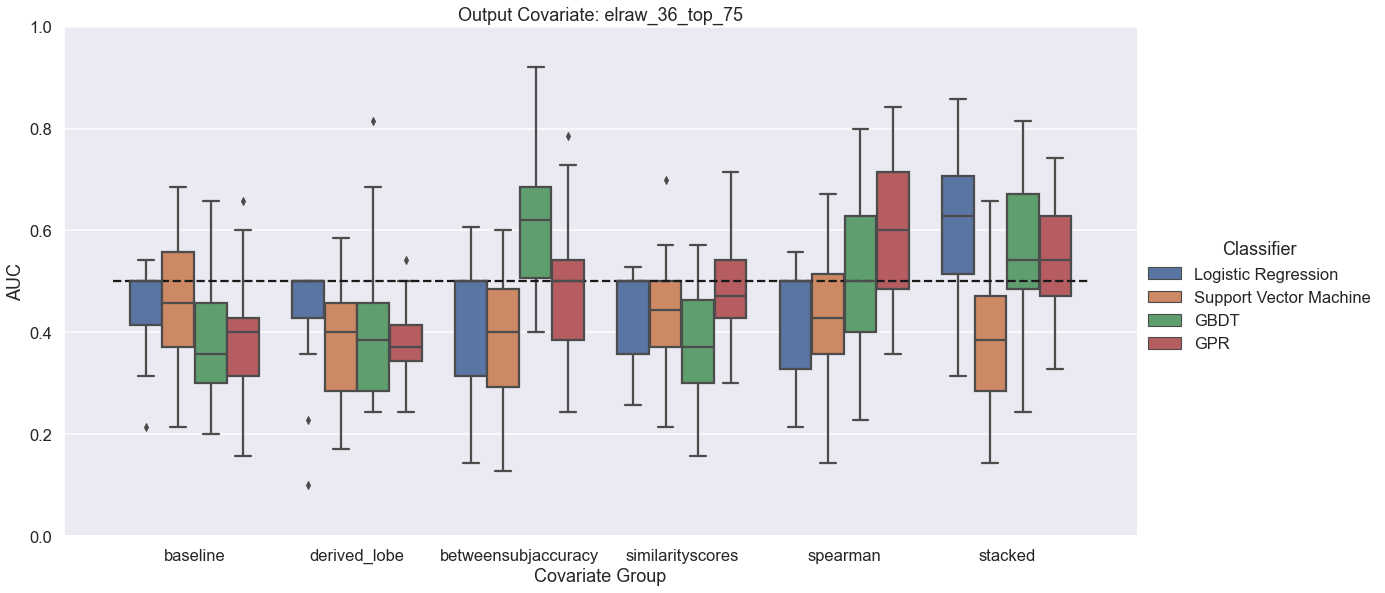

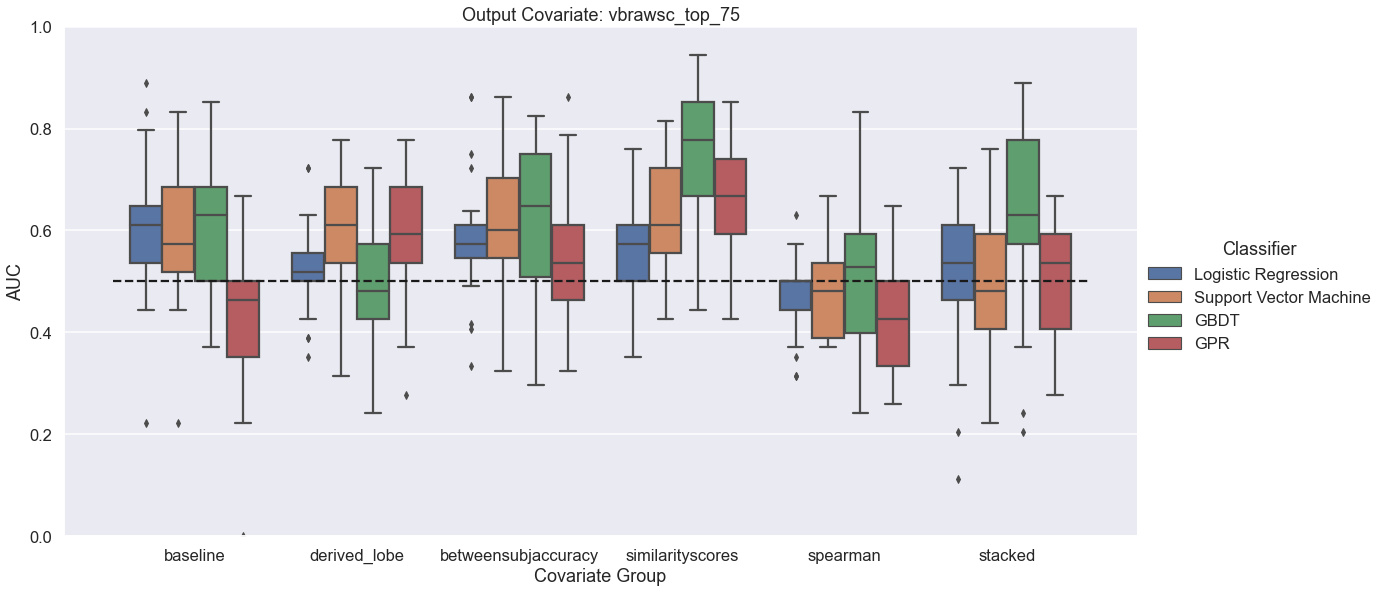

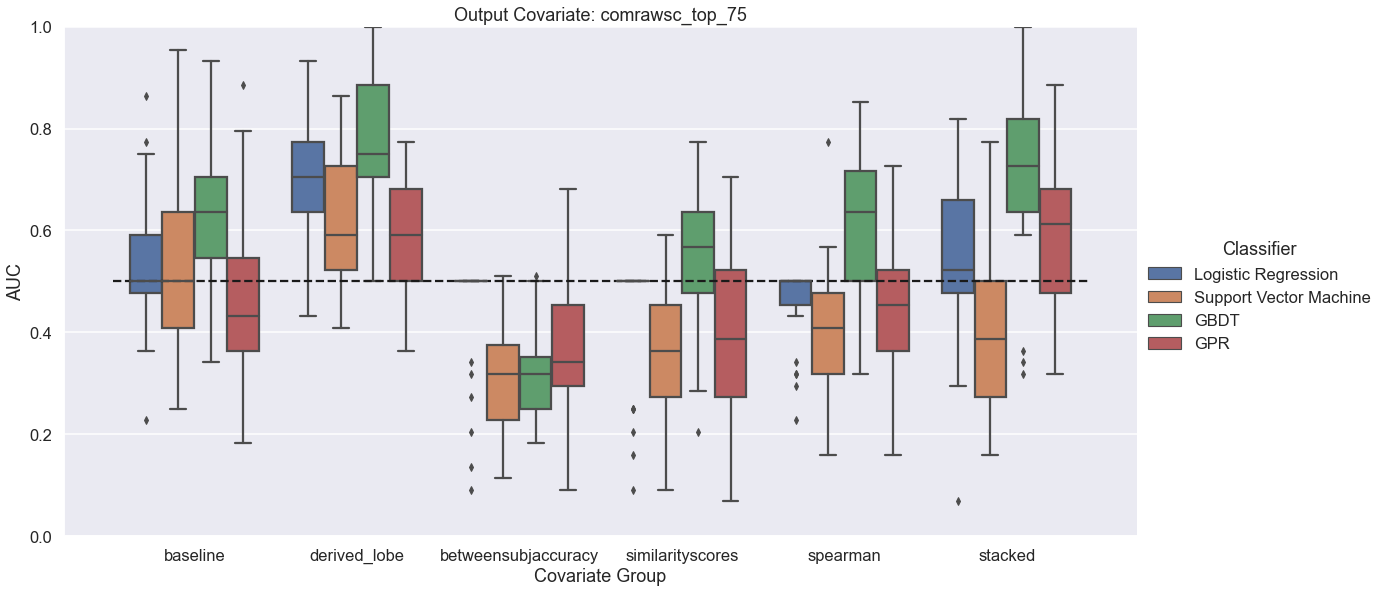

In [3]:
for output_variable in all_results.keys():
    if '_6_' in output_variable or '_24_' in output_variable:
        names_of_covariate_groups = crypto_names_of_covariate_groups
    else:
        names_of_covariate_groups = provide_names_of_covariate_groups
    results, outer_cv, df_displays = all_results[output_variable]
    for df in df_displays:
        df['model'] = df.index.name

    df = pd.concat(df_displays, 0).reset_index()
    df.columns = ['Covariate Group', f'Average AUROC (over {N_SPLITS_OUTER} folds)', f'Standard Deviation AUROC (over {N_SPLITS_OUTER} folds)', 'Classifier']

    auc = []
    model = []
    feature_names = []
    
    for key, value in results.items():
        model += [key] * (len(names_of_covariate_groups) + 1) * N_SPLITS_OUTER
        x = value['test_score']
        for i in range(N_SPLITS_OUTER):
            auc += list(x[i, :])
            feature_names += names_of_covariate_groups + ['stacked']

    df_boxplot = pd.DataFrame({
        'Classifier': model,
        'AUC': auc,
        'Covariate Group': feature_names
    })

    title=f'Output Covariate: {output_variable}'
    sns.catplot(x="Covariate Group", y="AUC", hue="Classifier",  data=df_boxplot, kind="box", dodge=True, height=8, aspect=2);
    plt.plot([-0.5, len(names_of_covariate_groups) + 0.5], [0.5, 0.5], '--', c='k', label='Random Performance');
    plt.ylim(0, 1)
    plt.title(title)
